<a href="https://colab.research.google.com/github/mgarciasanes/metodosdeagrupamiento_nosupervisado/blob/master/03_espectral_laplace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> Aplicación de los Métodos de Agrupamiento</h1></center>
<center><h1> Aprendizaje No Supervisado</h1></center>
<center><h1> Agrupamiento Espectral : Matriz Laplaciana</h1></center>
<br>

### - Alexandro López González
### - Leonardo Pacheco Garduño
### - Manuel Garcia Sanes
<br>
<br>

En este notebook, realizaremos los siguiente:

- Aplicación del algoritmo Matriz Laplaciana  a los dos datasets seleccionados. 

- Evaluación de los resultados utilizando métricas intrínsecas o extrínsecas según sea el caso

- Análisis del resultado
<br>
<br>


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.cluster import KMeans


Para comenzar, cargamos el conjunto de datos con el que trabajaremos:


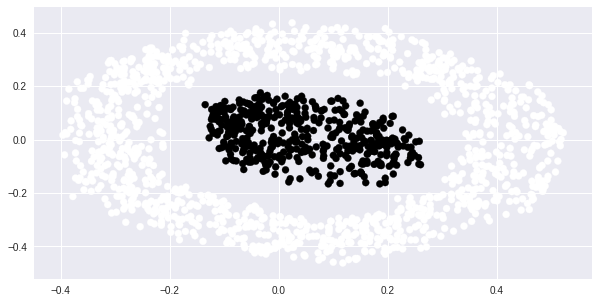

In [5]:
np.random.seed(17) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_circulos_concentricos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]
Dy = D[:,2]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy)


Con este dataset trabajaremos y estudiaremos en esta práctica el agrupamiento espectral y sus diferentes configuraciones. Para empezar, será necesario calcular la matriz de similitudes. Para ello, usaremos la función de la libreria Scikit-learn para obtener la matriz de distancias, concretamente, usando la métrica euclidiana. 

Para transformar la matriz de distancias en una de similitudes se usa la función exponencial de la siguiente manera:


In [0]:
from sklearn.metrics.pairwise import euclidean_distances

mSimilitud = euclidean_distances(Dx)

sigma = 0.1
mSimilitud = np.exp(-np.power(mSimilitud,2)/(2*sigma**2))


Tal y como se ha visto en la parte teórica, el agrupamiento espectral consiste en 4 pasos básicos: la obtención de la matriz de adyacencias o afinidad, la obtención de la matriz Laplaciana, el cálculo de los vectores y valores propios de esta última, y el clustering mediante K-means (u otra técnica tradicional). Iremos paso a paso revisando los diferentes pasos.

Para comenzar, calcularemos la matriz de afinidad completa, que contempla que todos los ejemplos (nodos) están conectados con todos:


In [0]:
def matriz_afinidad_completa(mSimilitud):
    mAfinidad = mSimilitud #### TU CODIGO AQUI ####
    return mAfinidad


La matriz de afinidad mediante umbral sólo conecta aquellos nodos cuya similitud sea mayor que cierto umbral fijado. Todos aquellos pares de ejemplos (nodos) que superen el umbral reciben como valor $W_{ij}$ el valor de similitud correspondiente, y 0 cuando no están conectados:


In [0]:
def matriz_afinidad_umbral(mSimilitud, umbral=0.1):
    mAfinidad = np.zeros(mSimilitud.shape)
    mAfinidad[mSimilitud >= umbral] = mSimilitud[mSimilitud >= umbral]
    return mAfinidad


La matriz de afinidad mediante KNN sólo conecta aquellos nodos que sean uno de los ($K$) vecinos más cercanos (similares) entre ellos. Todos aquellos pares de ejemplos (nodos) que sean vecinos cercanos reciben como valor $W_{ij}$ el valor de similitud correspondiente, y 0 cuando no están conectados. Otra alternativa es calcular dos matrices, $W^1$ y $W^2$, tal que $W^1_{ij}$ toma valor 1 cuando el nodo $j$ es uno de los $K$ vecinos más similares de $i$, y $W^2_{ij}$ toma valor 1 cuando el nodo $i$ es uno de los K vecinos más similares de $j$. La matriz de afinidad devuelta sería $(W^1+W^2)/2$:


In [0]:
def matriz_afinidad_KNN(mSimilitud, KNN=5):
    auxM = mSimilitud.copy()
    np.fill_diagonal(auxM, 0)

    mAfinidadA = np.zeros(auxM.shape)
    a = (np.argsort(-auxM, axis=0)[0:KNN,:]).flatten()
    b = np.tile(np.arange(auxM.shape[0]),KNN)
    mAfinidadA[a,b] = 1
    np.fill_diagonal(mAfinidadA, 1)

    mAfinidadB = np.zeros(auxM.shape)
    a = np.repeat(np.arange(auxM.shape[0]),KNN)
    b = (np.argsort(-auxM, axis=1)[:,0:KNN]).flatten()
    mAfinidadB[a,b] = 1
    np.fill_diagonal(mAfinidadB, 1)

    return (mAfinidadA+mAfinidadB)/2


Una vez obtenida la matriz de afinidad, el siguiente paso es calcular una matriz Laplaciana. Como se ha visto en la parte teórica, hay tres manera de hacerlo.

La matriz Laplaciana no normalizada tiene, en cada celda $L_{ij}$, con $i\neq j$, el valor $-W_{ij}$, y en su diagonal principal $L_{ii}=D_{i}$, donde $D_i$ es la suma de $W_{ij}$ para toda la fila (para todo $j$):


In [0]:
def matriz_Laplaciana(mAfinidad):
    R = -mAfinidad.copy()
    np.fill_diagonal(R, np.sum(mAfinidad,axis=1)-1)
    return R


La matriz Laplaciana normalizada (o de camino aleatorio) se calcula como la diferencia entre la matriz identidad y el producto de la inversa de la matriz diagonal de grado, $D$, y la matriz de afinidad:


In [0]:
def matriz_Laplaciana_normalizada(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I - D.dot(mAfinidad)


Para obtener la matriz Laplaciana normalizada simétrica se calcula, $D'$ la inversa de la raiz cuadrada de la matriz diagonal de grado, $D$. El resultado final se obtiene tras calcular la diferencia entre la matriz identidad y el producto de $D'$, la matriz de afinidad y $D'$ de nuevo:


In [0]:
def matriz_Laplaciana_normalizada_simetrica(mAfinidad):
    D = np.sum(mAfinidad,axis=1)
    D = D**(-1.0/2)
    I = np.diag( np.ones(D.size) )
    D = np.diag(D)
    return I - D.dot(mAfinidad).dot(D)


Con esto, sólo nos queda obtener los valores y vectores propios de la matriz Laplaciana, para lo que usaremos la función eig de la libraría scipy. Los primeros vectores propios, ordenados según su valor propio correspondiente, se recogen y se usan como variables de nuestro nuevo dataset, el conjunto de datos transformado que usaremos posteriormente para realizar el clustering K-means:


In [0]:
def agrupamiento_espectral(mSimilitud, K, afinidad = matriz_afinidad_completa, 
                           laplaciana = matriz_Laplaciana_normalizada, **kwargs):
    mAfinidad = afinidad(mSimilitud, **kwargs)
    mLaplaciana = laplaciana(mAfinidad)

    valores_pr, vectores_pr = linalg.eig(mLaplaciana)
    orden = valores_pr.real.argsort()
    vectores_pr = vectores_pr.real[:, orden]

    Dx_trans = vectores_pr[:, np.arange(K)]
    modelo = KMeans(n_clusters = K)
    modelo = modelo.fit(Dx_trans)
    Dyp = modelo.predict(Dx_trans)

    return [mAfinidad, Dyp]


Con esta última función, ya se puede proceder a realizar el agrupamiento:


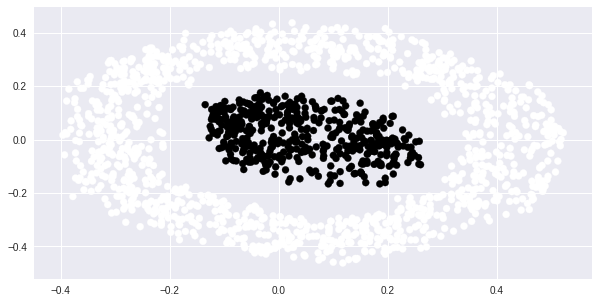

In [14]:
K = 2
knn = 40
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_KNN,
                                        matriz_Laplaciana_normalizada, KNN=knn)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)


Otra manera de realizar el agrupamiento es usar la afinidad de umbral y la matriz normalizada:


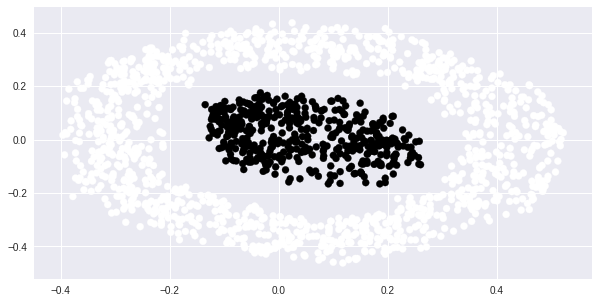

In [15]:
K = 2
eps = 0.8
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_umbral,
                                        matriz_Laplaciana_normalizada, umbral=eps)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)


Una tercera prueba podría consistir en usar la afinidad completa y la matriz normalizada simétrica:


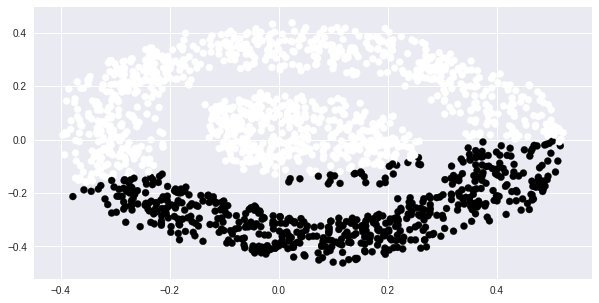

In [16]:
K = 2
mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                        matriz_afinidad_completa,
                                        matriz_Laplaciana_normalizada_simetrica)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

Se puede observar que este último ejemplo, esta combinación específica de parámetros para el algoritmo, no devuelve el restultado esperado. ¿Cuál es la razón? **ÉSTA ES UNA DE LAS PREGUNTAS A RESPONDER EN EL CAMPUS VIRTUAL**

<hr>
<h2>Implementaciones en librerías de Python</h2>

La librería ScikitLearn ya implementa el algoritmo de clustering espectral.

Están implementadas (parámetro affinity) las matrices de afinidad completa y KNN. Usa la matriz Laplaciana normalizada.


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


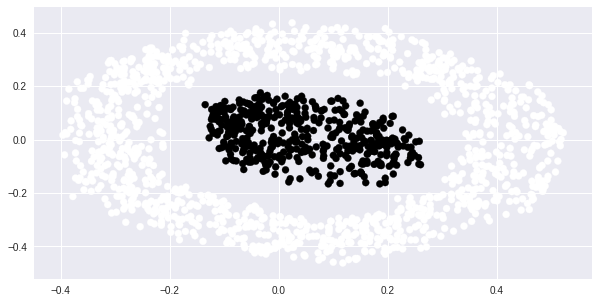

In [0]:
from sklearn.cluster import SpectralClustering
K = 2
knn = 5
clustering = SpectralClustering(n_clusters = K, 
                                affinity = 'nearest_neighbors', n_neighbors = knn,
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)

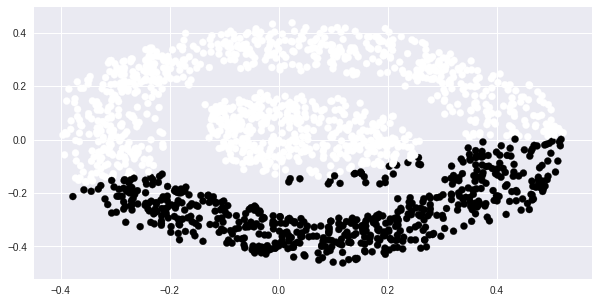

In [0]:
K=2
clustering = SpectralClustering(n_clusters = K, 
                                gamma=1./(2*sigma**2),
                                random_state = 0).fit(Dx)

fig, ax = plt.subplots(figsize = (10,5))
ax.scatter(Dx[:,0], Dx[:,1], c=clustering.labels_)


Con la siguiente función dibujaremos los resultados del clustering (fijado un K) usando diferentes criterios. Podemos usar diferentes datasets de ejemplo (ver aquellos que tiene 2 dimensiones en:
https://github.com/jhernandezgonzalez/unsupervisedlearning/tree/master/datasets

Podemos hacer unas pruebas para ganar algunas intuiciones sobre cuál es la mejor estrategia según el tipo de datos...


In [0]:
def plot_varios(Dx, Dy, K, knn=5, eps=0.8):
    mSimilitud = euclidean_distances(Dx)
    sigma = 0.1
    mSimilitud = np.exp(-np.power(mSimilitud,2)/(2*sigma**2))
    
    fig, ax = plt.subplots(2,3, figsize=(20,10))
    ax[0,0].scatter(Dx[:,0], Dx[:,1], c=Dy)
    ax[0,0].set_title('Datos originales')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_KNN,
                                            matriz_Laplaciana, KNN=knn)
    ax[0,1].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[0,1].set_title('Laplaciana no normalizada, KNN')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_completa,
                                            matriz_Laplaciana)
    ax[0,2].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[0,2].set_title('Laplaciana no normalizada, Completa')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_umbral,
                                            matriz_Laplaciana_normalizada, umbral=eps)
    ax[1,0].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[1,0].set_title('Laplaciana normalizada, Umbral')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_KNN,
                                            matriz_Laplaciana_normalizada, KNN=knn)
    ax[1,1].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[1,1].set_title('Laplaciana normalizada, KNN')
    
    mAfinidad, Dyp = agrupamiento_espectral(mSimilitud, K, 
                                            matriz_afinidad_completa,
                                            matriz_Laplaciana_normalizada)
    ax[1,2].scatter(Dx[:,0], Dx[:,1], c=Dyp)
    ax[1,2].set_title('Laplaciana normalizada, Completa')

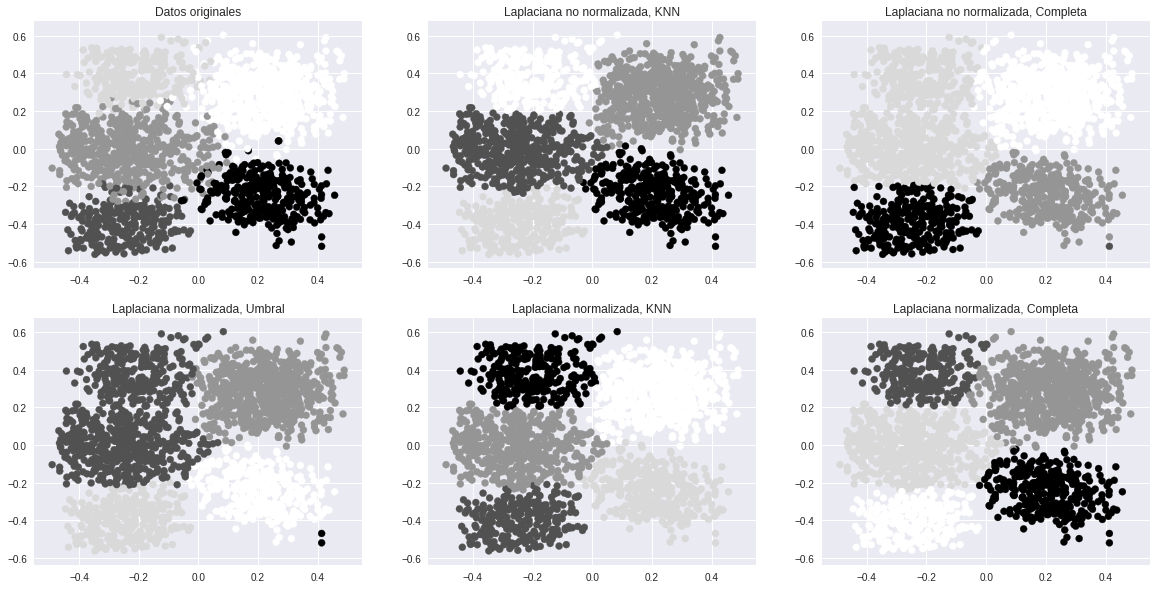

In [0]:
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_inseparable.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,5)

In [0]:
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_dos_remolinos.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,2,knn=4)

In [0]:
data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_cuatro_diferente_medida.csv'
D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]
plot_varios(Dx,Dy,4)